# Librerie

In [1]:
pip install mtcnn

In [2]:
!pip install keras_vggface

In [3]:
import zipfile
import shutil 
import os
from time import time
from datetime import datetime as dt

from matplotlib import pyplot as plt
import numpy as np
import random
import cv2

from tensorflow import keras
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.models import load_model
from keras.preprocessing import image
from keras import backend as K
from keras import Model

from mtcnn.mtcnn import MTCNN

from sklearn.neighbors import KDTree
import joblib

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Funzioni

In [5]:
# funzione per visualizzare piu immagini insieme
def display_img(img_list, nrow = 1, ncol = 0, size = (10,10), text = []):

  if not ncol:
    ncol = len(img_list)
  
  fig = plt.figure(figsize=(size[0], size[1]))
  k = 0
  for i in range(nrow):
    for j in range(ncol):
      current_plot = fig.add_subplot(nrow, ncol, k+1)
      if k < len(text):
        current_plot.title.set_text(text[k])
      plt.imshow(img_list[k])
      k += 1


In [6]:
def retrieval(paths, query_path, tree, net, prep_fun, num_image):
  
  # funzione che restituisce le prime 'num_image' piu' simili alla query
  
  
  query_image = kimage.load_img(query_path, target_size=(224, 224))

  # estrazione features della query
  query_features = neural_features(query_image, net, prep_fun = prep_fun )
  query_features = np.expand_dims(query_features, axis=0)

  # plot delle immagini piu simili
  dist, ind = tree.query(query_features, k=num_image)
  for i in range(0, num_image):
    print(paths[ind[0][i]])
    display_img([kimage.load_img(query_path), kimage.load_img(paths[ind[0][i]])])

In [7]:
def neural_features(img, net = None, prep_fun = None):

    x = kimage.img_to_array(img)
    
    # se no rete e no preprocessing non faccio niente
    if (net == None) & (prep_fun == None): 
      return x.flatten()
    
    elif prep_fun != None:

      # preprocessing
      x = prep_fun(x)
    
    x = np.expand_dims(x, axis=0)
    
    # estrazione features
    f = net.predict(x)
    return f.flatten()


In [8]:
def face_cropper_mtcnn(image, detector):

  # bbox regression con mtcnn


  # predict dei bboxes, l'output e' una lista di dizionari,
  # ogni dizionario ha come chiave 'box' che contiene le coordinate del
  # box (x, y, width, height)
  # oltre ai punti chiave tipo occhi e naso..
  faces = detector.detect_faces(image)

  # itero sui volti identificati
  cropped_list = []
  for face in faces:
    x, y, w, h = face['box']
    cropped_img = image[y:y+h,x:x+w]
    #cropped_img = cv2.resize(cropped_img, target_size, cv2.INTER_CUBIC)
    cropped_list.append(cropped_img)

  if not np.prod(cropped_list[0].shape):
    cropped_list = [image]
  return cropped_list[0]

In [9]:
def features_cropped_images(images, paths, net = None, prep_fun = None, target_size = (224,224)):

  # estrazione feature su immagini con volto ritagliato
  failed_cropped_path = []
  cropped_path = []
  x = []
  i = 0
  for img in images:
    print(paths[i])
    # se va in errore il resize (riquadro con alezza nulla) inserisco fra i fail
    try:
      img = cv2.resize(img, target_size, cv2.INTER_CUBIC)
      if prep_fun:
        img = prep_fun(img)
      img = np.expand_dims(img, 0).astype('float16')
      
      x.append(img)
      cropped_path.append(paths[i])
    except:
      failed_cropped_path.append(paths[i])
    if i%1000 == 0:
      print(i)
    i+=1

  f = np.concatenate(x,0)
  if net:
    f = net.predict(f).astype('float16')
  
  return f, cropped_path, failed_cropped_path


In [10]:
def retrieval_cropping(paths, query_path, tree, net, prep_function, num_image, target_size = (244,244), cropping = False, detector = None):

  # immagine di query
  query_image = cv2.imread(query_path)
  
  query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)

  # cropping se previsto
  cropped = query_image.copy()
  if cropping:
    cropped = face_cropper_mtcnn(cropped, detector = detector)
  else:
    cropped = cv2.resize(query_image, target_size)

  # estrazione features
  query_features, query_paths, query_fail = features_cropped_images(
      [cropped],
      [query_path],
      net,
      prep_function,
      target_size = target_size
      )
  
  # best k images
  dist, ind = tree.query(query_features, k = num_image)
  for i in range(0, num_image):

    print(dist[0][i])
    # immagine corrente
    matching = cv2.imread(paths[ind[0][i]])
    matching = cv2.cvtColor(matching, cv2.COLOR_BGR2RGB)
    
    display_img([query_image, matching], text=['', paths[ind[0][i]].split('/')[-2]])

Importazione dati

In [13]:
path = '/content/drive/MyDrive/DSIM/'
shutil.copyfile(path+'image_retrieval/dataset/MSRA-CFW (1)/Dataset/thumbnails_features_deduped_publish.zip', 'imvip.zip')

'imvip.zip'

In [14]:
imvip_zipped = zipfile.ZipFile('imvip.zip')
imvip_zipped.extractall()
imvip_zipped.close()

# Score Mobilnet con Dataset originale

Per riproducibilità, le parti commentate non sono da eseguire.

In [15]:
loaded_mobilenet = np.load('/content/drive/MyDrive/DSIM/image_retrieval/features_mobilenet.npz')
loaded_mobilenet['X_train'].shape

(202941, 1280)

In [16]:
#tree_mobilenet = KDTree(loaded_mobilenet['X_train']) #costruzione kdtree

In [ ]:
#joblib.dump(tree_mobilenet, 'mobilenet_kdtree.joblib')
#!cp mobilenet_kdtree.joblib '/content/drive/MyDrive/DSIM/image_retrieval/

In [17]:
#mobilenet = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', 
#                                     pooling='max', input_shape=(224, 224, 3))

9412608/9406464 [==============================] - 0s 0us/step


In [21]:
path = '/content/drive/MyDrive/DSIM/'
shutil.copyfile(path+'image_retrieval/mobilenet_kdtree.joblib', 'mobilenet_kdtree.joblib')
tree_mobilenet = joblib.load('mobilenet_kdtree.joblib')

kobe-bryant.jpg
0
85.65953375760452
89.35231775859499
90.82258413267643


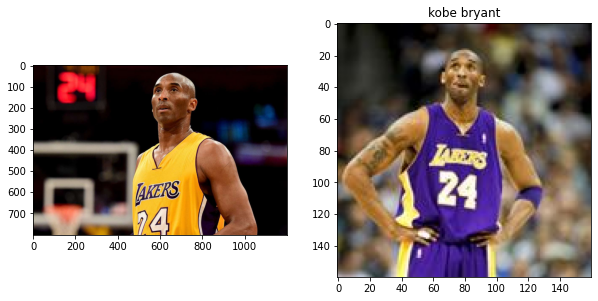

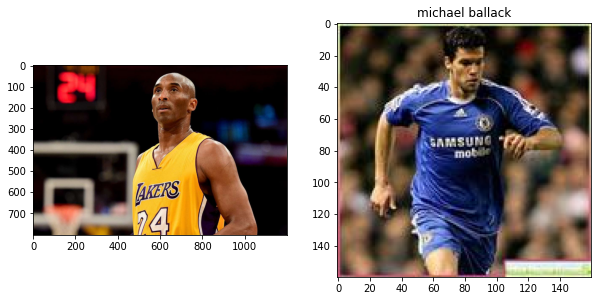

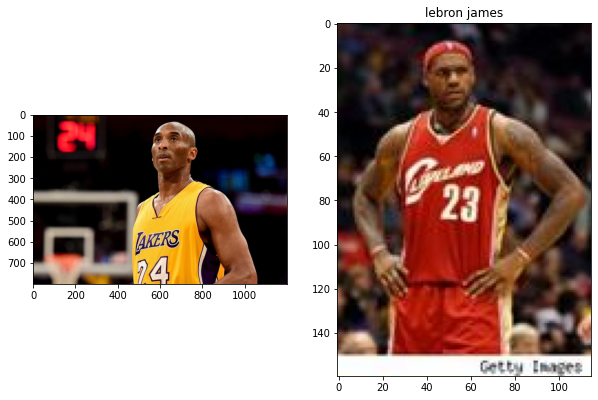

In [23]:
retrieval_cropping(loaded_mobilenet['paths'], 'kobe-bryant.jpg', 
                   tree_mobilenet, mobilenet, mobilenet_v2.preprocess_input, 3, target_size = (224,224))


# Score VGG Face con dataset originale

In [25]:
pip install keras_applications

     |████████████████████████████████| 51kB 6.6MB/s 


In [27]:
import keras_applications
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

In [28]:
vggface = VGGFace(include_top=False, input_shape=(224, 224, 3), 
                       pooling='avg', model = 'resnet50')

94699520/94694792 [==============================] - 1s 0us/step


In [29]:
loaded_vggface = np.load('/content/drive/MyDrive/DSIM/image_retrieval/features_vggface.npz')
loaded_vggface['X_train'].shape

(202941, 2048)

In [ ]:
#tree_vggface = KDTree(loaded_vggface['X_train'])

In [ ]:
#joblib.dump(tree_vggface, 'vgg_kdtree.joblib')
#!cp vgg_kdtree.joblib '/content/drive/MyDrive/DSIM/image_retrieval/

In [33]:
path = '/content/drive/MyDrive/DSIM/'
shutil.copyfile(path+'image_retrieval/vgg_kdtree.joblib', 'vgg_kdtree.joblib')
tree_vggface = joblib.load('vgg_kdtree.joblib')

/content/thumbnails_features_deduped_publish/christina aguilera/762.jpg
/content/thumbnails_features_deduped_publish/anna sui/114.jpg
/content/thumbnails_features_deduped_publish/keira knightley/351.jpg


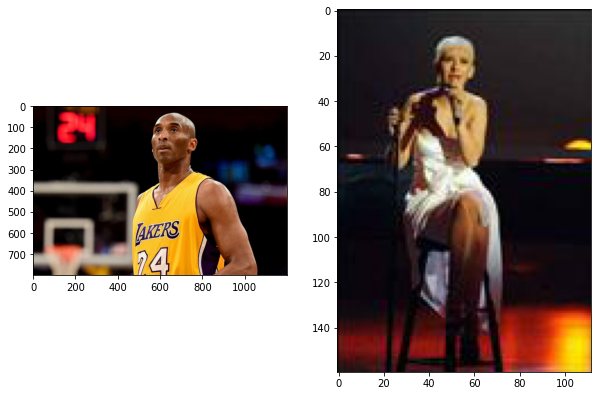

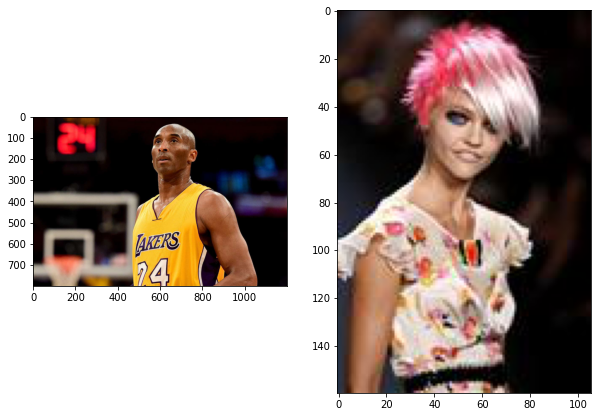

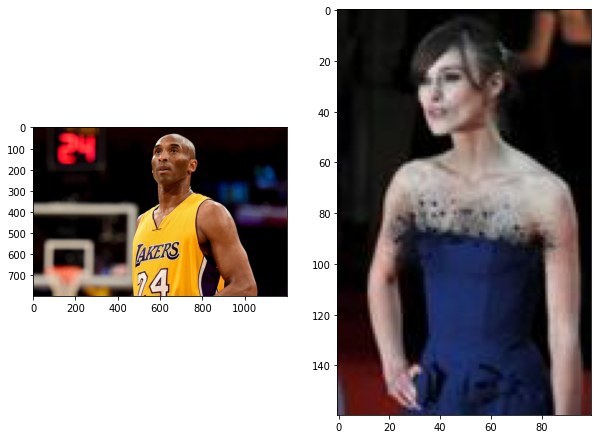

In [35]:
retrieval(loaded_vggface['paths'], 'kobe-bryant.jpg', tree_vggface, 
          vggface, utils.preprocess_input, 3)


# Score con Facenet e dataset croppato

In [12]:
shutil.copyfile('/content/drive/MyDrive/DSIM/image_retrieval/facenet_keras.h5', 'facenet_keras.h5')
facenet_base = load_model('facenet_keras.h5')

In [11]:
features_facenet_cropped = np.load('/content/drive/MyDrive/DSIM/image_retrieval/features_facenet_cropped.npz')

In [13]:
#tree_facenet = KDTree(features_facenet_cropped['features_facenet'])
cropped_path_facenet = features_facenet_cropped['cropped_path_facenet']

In [ ]:
#joblib.dump(tree_facenet, 'facenet_kdtree.joblib')
#!cp facenet_kdtree.joblib '/content/drive/MyDrive/DSIM/image_retrieval/

In [14]:
def facenet_preprocessing(img):
  mean, std = img.mean(), img.std()
  img = (img - mean) / std
  return img

In [15]:
facenet = Model(inputs = facenet_base.inputs, outputs = facenet_base.get_layer('AvgPool').output)

In [16]:
path = '/content/drive/MyDrive/DSIM/'
shutil.copyfile(path+'image_retrieval/facenet_kdtree.joblib', 'facenet_kdtree.joblib')
tree_facenet = joblib.load('facenet_kdtree.joblib')

/content/kobe-bryant.jpg
0
10.56491732175176
10.963200509903148
11.11820198334212


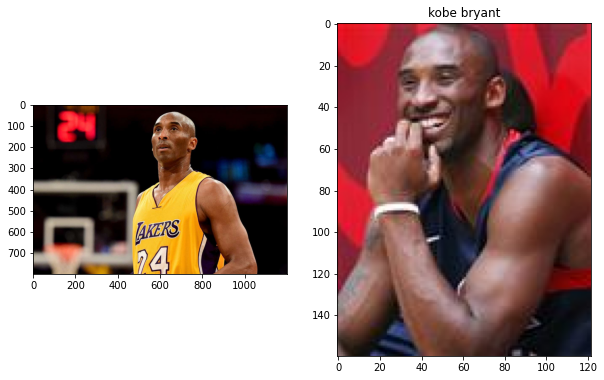

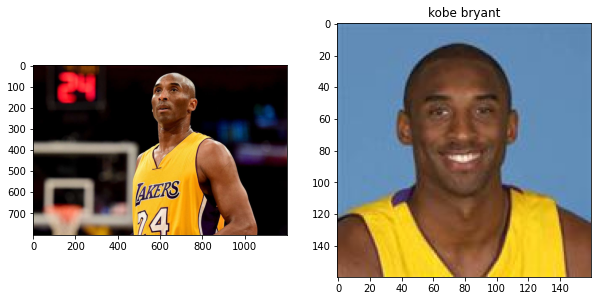

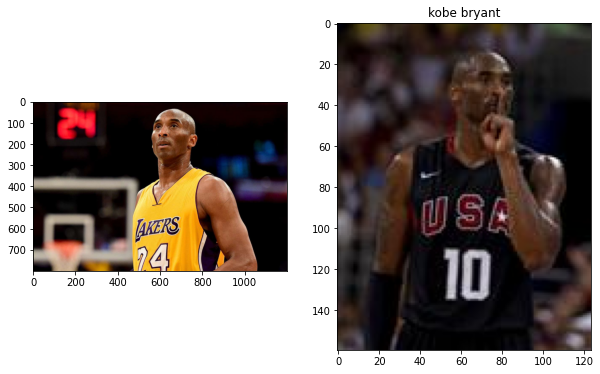

In [18]:
detector = MTCNN()
retrieval_cropping(
    paths = cropped_path_facenet,
    query_path = '/content/kobe-bryant.jpg',
    tree = tree_facenet,
    net = facenet,
    prep_function = facenet_preprocessing,
    num_image = 3,
    target_size = (160, 160),
    cropping = face_cropper_mtcnn,
    detector = detector
    )

# Score Mobilenet su dataset croppato

In [19]:
mobilenet = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', 
                                     pooling='max', input_shape=(160, 160, 3))

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# estrazione delle features
'''features_mobilenet, cropped_path_mobilenet, fail_paths_mobilenet = features_cropped_images(
    loaded_cropped['cropped_images'].tolist(),
    loaded_cropped['paths'],
    mobilenet,
    prep_fun = mobilenet_v2.preprocess_input,
    target_size = (160, 160)
    )'''

In [ ]:
#tree_mobilenet_cropped = KDTree(features_mobilenet)

In [ ]:
#joblib.dump(tree_mobilenet_cropped, 'cat_kdtree.joblib')
#!cp cat_kdtree.joblib '/content/drive/MyDrive/DSIM/image_retrieval/

In [20]:
path = '/content/drive/MyDrive/DSIM/'
shutil.copyfile(path+'image_retrieval/cat_kdtree.joblib', 'cat_kdtree.joblib')
tree_mobilenet_cropped = joblib.load('cat_kdtree.joblib')

In [22]:
cropped_path_mobilenet = np.load('/content/drive/MyDrive/DSIM/image_retrieval/cropped_mobilenet_path.npz')

/content/kobe-bryant.jpg
0
65.5966558230514
65.8526272665367
67.06703825771217


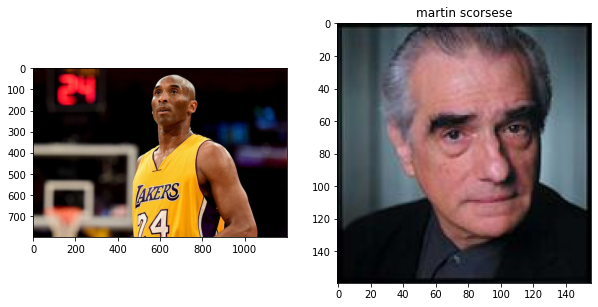

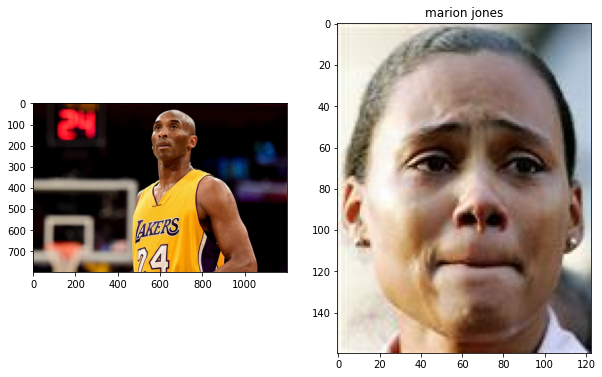

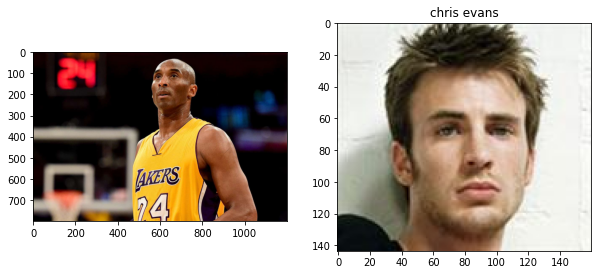

In [25]:
detector = MTCNN()
retrieval_cropping(
    cropped_path_mobilenet['paths'],
    '/content/kobe-bryant.jpg',
    tree_mobilenet_cropped,
    mobilenet,
    prep_function = mobilenet_v2.preprocess_input,
    num_image = 3,
    target_size = (160, 160),
    cropping = face_cropper_mtcnn,
    detector = detector
    )